In [1]:
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

class ClassificationModelManager:
    """
    Manages multiple classification models for different food categories."""
    def __init__(self, classification_paths: dict):
        self.classification_models = {}
        for category, path in classification_paths.items():
            try:
                self.classification_models[category] = YOLO(path)
            except Exception as e:
                print(f"Error loading model for category '{category}': {e}")
                self.classification_models[category] = None
        
    def get_model(self, category: str):
        """Returns a specific classification model based on the category."""
        return self.classification_models.get(category)
    
    def get_all_models(self):
        """Returns all classification models. (dictionary)"""
        return self.classification_models
    
class FoodDetModel:
    def __init__(self, detection_model_path: str, classification_config: dict,
                 detection_id_to_name: str, det_to_cls_group: str):
        
        self.detection_model = YOLO(detection_model_path)

        self.cls_manager = ClassificationModelManager(classification_config)

        self.classification_models = self.cls_manager.get_all_models()

        with open(detection_id_to_name, 'r') as f:
            self.detection_id_to_name = json.load(f)

        self.name_to_id = {v: int(k) for k, v in self.detection_id_to_name.items()}

        with open(det_to_cls_group, 'r') as f:
            self.det_to_cls_group = json.load(f)

    def _expand_bbox(self, bbox, image_shape, scale=1.1):
        """Expand bounding box slightly while staying within image bounds."""
        x1, y1, x2, y2 = bbox
        w, h = x2 - x1, y2 - y1
        cx, cy = x1 + w / 2, y1 + h / 2
        new_w, new_h = w * scale, h * scale

        x1n = max(0, int(cx - new_w / 2))
        y1n = max(0, int(cy - new_h / 2))
        x2n = min(image_shape[1] - 1, int(cx + new_w / 2))
        y2n = min(image_shape[0] - 1, int(cy + new_h / 2))

        return [x1n, y1n, x2n, y2n]
    
    def run(self, image_path: str, conf_threshold=0.3, det_imgsz=640,
            vis=False, vis_crops=False, verbose=True):
        """Run detection and classification on the input image."""
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Image at path '{image_path}' could not be loaded.")
        
        vis_img = image.copy() if vis else None

        ### DETECTION ###
        det_results = self.detection_model.predict(source=image, imgsz=det_imgsz, conf=conf_threshold, agnostic_nms=True, save=False, verbose=False)

        all_boxes = []
        final_outputs = []

        if vis:
            img_bgr = det_results[0].plot()
            img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(8, 8))
            plt.imshow(img_rgb)
            plt.axis('off')
            plt.show()

        ### CLASSIFICATION ###

        for det in det_results:
            boxes = det.boxes.xyxy.cpu().numpy()
            class_ids = det.boxes.cls.cpu().numpy()
            scores = det.boxes.conf.cpu().numpy()

            for i, box in enumerate(boxes):
                x1, y1, x2, y2 = map(int, box)
                det_class_id = int(class_ids[i])
                det_conf_score = float(scores[i])
                det_class_name = self.detection_id_to_name[str(det_class_id)]

                all_boxes.append((x1, y1, x2, y2, det_class_name, det_conf_score))

                # --- Find which segmentation model to use ---
                seg_group = None
                for group_name, class_list in self.det_to_cls_group.items():
                    if det_class_name in class_list:
                        seg_group = group_name
                        if verbose:
                            print(f"Detection '{det_class_name}' mapped to classification group '{seg_group}'")
                        break
                if seg_group is None:
                    if verbose:
                        print(f"No classification group found for detection '{det_class_name}'. Skipping classification.")
                    
                    final_outputs.append({
                        "pred_class_name": det_class_name,
                        "pred_class_id": det_class_id,
                        "bbox": [x1, y1, x2, y2],
                        "det_class_name": det_class_name,
                        "det_conf_score": det_conf_score,
                        "cls_group": None,
                        "top5_cls_results": []
                    })
                    continue

                expanded_box = self._expand_bbox((x1, y1, x2, y2), image.shape)
                ex1, ey1, ex2, ey2 = expanded_box
                crop_img = image[ey1:ey2, ex1:ex2].copy()

                cls_model = self.classification_models.get(seg_group)
                if cls_model is None:
                    if verbose:
                        print(f"No classification model found for group '{seg_group}'. Skipping classification.")
                    
                    final_outputs.append({
                        "pred_class_name": det_class_name,
                        "pred_class_id": det_class_id,
                        "bbox": [x1, y1, x2, y2],
                        "det_class_name": det_class_name,
                        "det_conf_score": det_conf_score,
                        "cls_group": seg_group,
                        "top5_cls_results": []
                    })
                    continue

                cls_results = cls_model.predict(source=crop_img, verbose=False)

                ## Process classification results
                top5 = []
                if cls_results and cls_results[0].probs is not None:
                    cls_res = cls_results[0]

                    names = cls_res.names
                    top5cls_ids = cls_res.probs.top5
                    top5probs = cls_res.probs.top5conf

                    for idx, prob in zip(top5cls_ids, top5probs):
                        top5.append({
                            "class_name": names[idx],
                            "probability": float(prob)
                        })
                final_outputs.append({
                    "pred_class_name": top5[0]["class_name"] if top5 else det_class_name,
                    "pred_class_id": self.name_to_id.get(top5[0]["class_name"], det_class_id) if top5 else det_class_id,
                    "bbox": [x1, y1, x2, y2],
                    "det_class_name": det_class_name,
                    "det_conf_score": det_conf_score,
                    "cls_group": seg_group,
                    "top5_cls_results": top5
                })

                if vis_crops:
                    for cls_res in cls_results:
                        im_array = cls_res.plot()
                        img_rgb = cv2.cvtColor(im_array, cv2.COLOR_BGR2RGB)
                        plt.figure(figsize=(6, 6))
                        plt.imshow(img_rgb)
                        plt.axis('off')
                        plt.show()

        return final_outputs

In [2]:
clsModelsDict = ({
    "meat": "classification_models/YOLO/meat.pt",
    "vegetable": "classification_models/YOLO/vegetable.pt",
    "fruit": "classification_models/YOLO/fruit.pt",
    "cheese-dairy" : "classification_models/YOLO/cheese-dairy.pt",
    "bread-pasta-grains": "classification_models/YOLO/bread-pasta-grains.pt",
    "nuts-seeds": "classification_models/YOLO/nuts-seeds.pt",
    "misc": "classification_models/YOLO/misc.pt",
})

model = FoodDetModel(
    detection_model_path="runs/detect/yolo_det_v4_m/weights/best.pt",
    classification_config=clsModelsDict,
    detection_id_to_name="pipeline_data/dicts/detect_classes_v4.json",
    det_to_cls_group="pipeline_data/dicts/det_to_cls_groups.json"
)


In [72]:
import os
from google import genai
from google.genai import types

def generate_recipe(ingredients_list, meal_type, response_lang="English"):
    """
    Generates a recipe based on a list of ingredients using Google Gemini 2.0.
    """
    
    # 1. Initialize the client
    # If the environment variable is not set, you can pass api_key="AIza..." directly here.
    try:
        client = genai.Client(api_key=os.environ.get("GOOGLE_API_KEY"))
    except Exception as e:
        return f"Error: API Key is missing or invalid. {e}"

    # 2. Prepare the prompt
    ingredients_str = ", ".join(ingredients_list)
    
    prompt = f"""
    You are a professional chef.
    Create a {meal_type} recipe using these ingredients: {ingredients_str}.
    Assume basic pantry items (oil, salt, pepper) are available.
    
    IMPORTANT LANGUAGE INSTRUCTION:
    Generate the content of the recipe in **{response_lang}**.
    However, keep the JSON keys strictly in English.
    
    Return ONLY JSON format:
    {{
        "recipe_name": "Name of the dish (in {response_lang})",
        "time": "Time (e.g. 15 min)",
        "calories": 500,
        "ingredients": ["List of ingredients (in {response_lang})"],
        "instructions": ["Step 1 (in {response_lang})", "Step 2 (in {response_lang})"]
    }}
    """

    # 3. Generate content
    try:
        response = client.models.generate_content(
            model="gemini-2.0-flash", 
            contents=prompt,
            config=types.GenerateContentConfig(
                response_mime_type="application/json"  # Forces JSON output for your app
            )
        )
        return response.text
        
    except Exception as e:
        return f"Error generating recipe: {e}"

WARNING imgsz=[1800] must be multiple of max stride 32, updating to [1824]


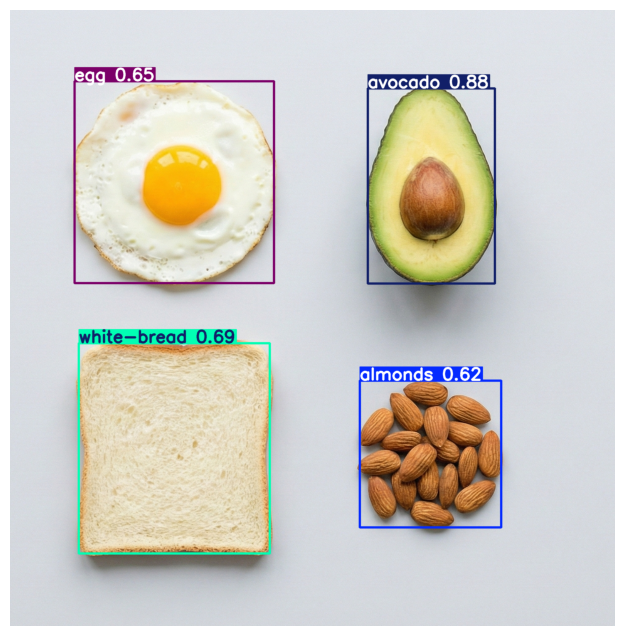

In [24]:
output = model.run(image_path="data/test_pics/ingredients/breakfast1.png", conf_threshold=0.3, det_imgsz=1800,
          vis=True, vis_crops=False, verbose=False)

In [27]:
def get_ingredients_from_output(model_output):
    """
    Extracts a list of ingredient names from the model output.
    """
    ingredients = []
    for item in model_output:
        ingredients.append(item["pred_class_name"])
    return ingredients

breakfast_ingredients = get_ingredients_from_output(output)
recipe_json = generate_recipe(breakfast_ingredients, meal_type="breakfast", response_lang="English")
print(recipe_json)

[
  {
    "recipe_name": "Avocado Toast with Fried Egg & Almonds",
    "time": "10 min",
    "calories": 450,
    "ingredients": [
      "2 slices white bread",
      "1 ripe avocado",
      "2 large eggs",
      "1/4 cup slivered almonds",
      "1 tablespoon olive oil",
      "Salt and pepper to taste"
    ],
    "instructions": [
      "Toast the bread slices to your desired level of crispness.",
      "While the bread is toasting, prepare the avocado. Halve the avocado, remove the pit, and scoop the flesh into a bowl. Mash with a fork until you reach your desired consistency. Season with salt and pepper.",
      "Heat olive oil in a non-stick skillet over medium heat. Fry the eggs to your liking (sunny-side up, over easy, etc.). Season with salt and pepper.",
      "Spread the mashed avocado evenly over the toasted bread.",
      "Top each slice of avocado toast with a fried egg.",
      "Sprinkle slivered almonds over the egg and avocado toast.",
      "Serve immediately."
    ]
 

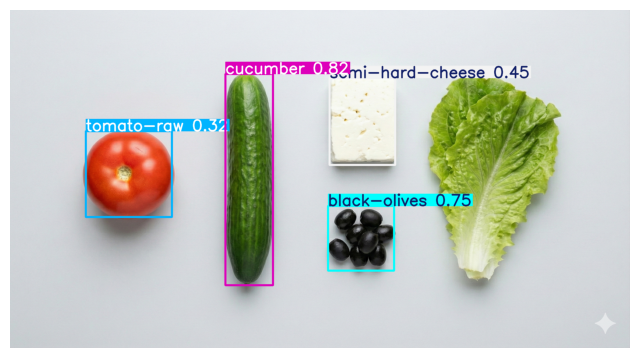

In [53]:
output = model.run(image_path="data/test_pics/ingredients/lunch1.png", conf_threshold=0.3, det_imgsz=800,
          vis=True, vis_crops=False, verbose=False)

In [55]:
dinner_ingredients = get_ingredients_from_output(output)
dinner_ingredients.append("lettuce")
print(dinner_ingredients)
recipe_json = generate_recipe(dinner_ingredients, meal_type="dinner", response_lang="English")
print(recipe_json)

['cucumber', 'beetroot', 'semi-hard-cheese', 'tomato-raw', 'lettuce']
[
  {
    "recipe_name": "Beetroot, Cucumber, and Cheese Salad with Tomato & Lettuce",
    "time": "20 min",
    "calories": 450,
    "ingredients": [
      "2 medium beetroots, cooked and cooled",
      "1 cucumber",
      "150g semi-hard cheese (e.g., Gouda, Edam)",
      "2 ripe tomatoes",
      "1 head of lettuce",
      "2 tablespoons olive oil",
      "1 tablespoon balsamic vinegar (optional)",
      "Salt and pepper to taste"
    ],
    "instructions": [
      "Wash and prepare the lettuce: Rinse the lettuce leaves thoroughly and pat dry. Tear into bite-sized pieces and arrange on a serving platter or in individual bowls.",
      "Prepare the vegetables: Dice the cooked beetroot, cucumber, and tomatoes into roughly 1cm cubes. Set aside.",
      "Prepare the cheese: Cut the semi-hard cheese into similar-sized cubes as the vegetables.",
      "Assemble the salad: Arrange the diced beetroot, cucumber, tomatoes, a

WARNING imgsz=[1900] must be multiple of max stride 32, updating to [1920]


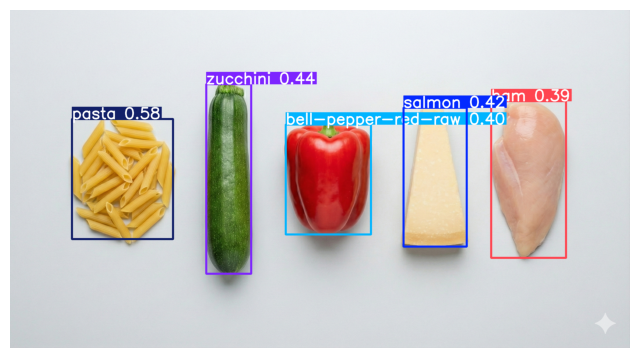

In [65]:
output = model.run(image_path="data/test_pics/ingredients/lunch2.png", conf_threshold=0.3, det_imgsz=1900,
          vis=True, vis_crops=False, verbose=False)

In [69]:
dinner_ingredients = get_ingredients_from_output(output)
dinner_ingredients.remove("salami")
dinner_ingredients.append("cheese")
print(dinner_ingredients)
recipe_json = generate_recipe(dinner_ingredients, meal_type="dinner", response_lang="English")
print(recipe_json)

['pasta', 'zucchini', 'bell-pepper-red-raw', 'ham', 'cheese']
[
  {
    "recipe_name": "Pasta with Ham, Zucchini, Bell Pepper, and Cheese",
    "time": "30 min",
    "calories": 650,
    "ingredients": [
      "1 pound pasta (penne or rotini)",
      "1 tablespoon olive oil",
      "1/2 cup diced ham",
      "1 red bell pepper, sliced",
      "2 medium zucchini, diced",
      "1/2 teaspoon salt",
      "1/4 teaspoon black pepper",
      "1 cup shredded cheese (cheddar or mozzarella)"
    ],
    "instructions": [
      "Cook pasta according to package directions. Drain and set aside.",
      "While pasta is cooking, heat olive oil in a large skillet over medium heat.",
      "Add ham and cook for 2-3 minutes, until lightly browned.",
      "Add bell pepper and zucchini to the skillet. Season with salt and pepper. Cook until vegetables are tender-crisp, about 5-7 minutes.",
      "Add cooked pasta to the skillet with the vegetables and ham. Toss to combine.",
      "Remove from heat and 

WARNING imgsz=[1800] must be multiple of max stride 32, updating to [1824]


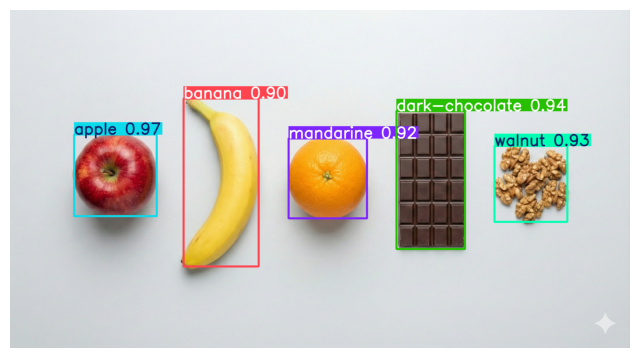

In [70]:
output = model.run(image_path="data/test_pics/ingredients/dessert1.png", conf_threshold=0.3, det_imgsz=1800,
          vis=True, vis_crops=False, verbose=False)

In [73]:
dessert_ingredients = get_ingredients_from_output(output)
print(dessert_ingredients)
recipe_json = generate_recipe(dessert_ingredients, meal_type="dessert", response_lang="English")
print(recipe_json)

['apple', 'chocolate', 'walnut', 'mandarine', 'banana']
[
  {
    "recipe_name": "Apple, Chocolate, and Nutty Delight",
    "time": "30 min",
    "calories": 450,
    "ingredients": [
      "2 medium apples, peeled, cored, and diced",
      "1 ripe banana, sliced",
      "2 mandarin oranges, peeled and segmented",
      "1/2 cup dark chocolate chips",
      "1/4 cup chopped walnuts",
      "2 tablespoons brown sugar",
      "1 teaspoon cinnamon",
      "1/4 cup orange juice",
      "1 tablespoon butter",
      "Pinch of salt"
    ],
    "instructions": [
      "Preheat oven to 375°F (190°C).",
      "In a bowl, combine diced apples, banana slices, mandarin orange segments, brown sugar, cinnamon, and a pinch of salt.",
      "Melt butter in a skillet over medium heat. Add the apple mixture and cook for about 5 minutes, stirring occasionally, until the apples begin to soften.",
      "Stir in the orange juice and simmer for another 2 minutes.",
      "Transfer the apple mixture to an ove